In [98]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from set_axes import set_ax

The model we initially considered is the Susceptible-Infected-Recovered (SIR). A slight generalization of it is the Susceptible-Infected-Exposed-Recovered (SIER). Since there is enough information available about the incubation period of Covid-19, it might be worth implementing both in first place. 
Starting with SIR, the dynamic equations are given by:
$$
\dot{S} = -\frac{\beta}{N} SI \\
\dot{I} = \frac{\beta}{N} SI - \gamma I \\
\dot{R} = \gamma I \\
S + I + R = N
$$
Where $R_0 = \beta/\gamma$ represents the average growth rate of the virus.
For a discrete time model a forwards Euler integration should suffice. We introduce the SIR class for an easier API. The following objects can be used for the evolution of the population within a single compartment of the population.

In [339]:
class SRI(object):
    
    def __init__(self, beta=0.2, gamma=0.5, S0=999, I0=1, R0=0):
        self.S0 = S0
        self.I0 = I0
        self.R0 = R0
        self.beta = beta
        self.gamma = gamma
        self.reset()
        self.N = S0 + I0 + R0
        
    def increments(self):
        deltaS = -self.beta*self.currentS*self.currentI/self.N
        deltaR = self.gamma*self.currentI
        deltaI = deltaS - deltaR
        return (deltaS, deltaI, deltaR)
    
    def integrate(self):
        pass
        
    def evolve(self, days):
        for i in range(days):
            self.integrate()
            
    def reset(self):
        self._S = [self.S0]
        self._I = [self.I0]
        self._R = [self.R0]
    
    @property
    def currentS(self):
        return self._S[-1]
    
    @property
    def currentI(self):
        return self._I[-1]
    
    @property
    def currentR(self):
        return self._R[-1]
    
    @property
    def time_elapsed(self):
        return len(self.S)
    
    @property
    def time(self):
        return np.arange(self.time_elapsed)
    
    @property
    def S(self):
        return np.array(self._S)
    
    @property
    def I(self):
        return np.array(self._I)
    
    @property
    def R(self):
        return np.array(self._R)
        
        
class DeterministicSRI(SRI):
    
    def __init__(self, **kargs):
        super().__init__(**kargs)
        
    def integrate(self):
        (deltaS, deltaI, deltaR) = self.increments()
        newS = self.currentS + deltaS
        newI = self.currentI + deltaI
        newR = self.currentR + deltaR
        self._S.append(newS)
        self._I.append(newI)
        self._R.append(newR)
            
            
class StochasticSRI(SRI):
    
    def __init__(self, **kargs):
        super().__init__(**kargs)
    
    def integrate(self):
        (deltaS, deltaI, deltaR) = self.increments()
        jumpS = -min(np.random.poisson(lam=np.abs(deltaS)), self.currentS)
        jumpR = min(np.random.poisson(lam=np.abs(deltaR)), self.currentI)
        jumpI = -(jumpS + jumpR)
        newS = self.currentS + jumpS
        newI = self.currentI + jumpI
        newR = self.currentR + jumpR
        self._S.append(newS)
        self._I.append(newI)
        self._R.append(newR)

In [340]:
# example use
params = {'beta' : 0.5, 'gamma' : 0.3, 'S0' : 999, 'I0' : 1, 'R0' : 0}
model1 = DeterministicSRI(**params)
model1.evolve(days=100)
model2 = StochasticSRI(**params)
model2.evolve(days=100)

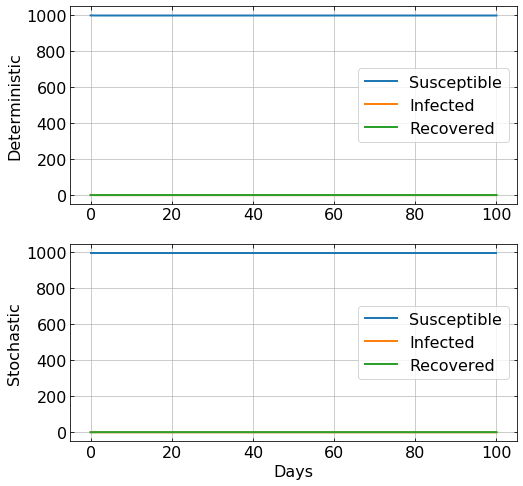

In [341]:
xlabel = 'Days'
ylabel1 = 'Deterministic'
ylabel2 = 'Stochastic'
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(model1.time, model1.S, linewidth=2, label='Susceptible')
ax1.plot(model1.time, model1.I, linewidth=2, label='Infected')
ax1.plot(model1.time, model1.R, linewidth=2, label='Recovered')
ax2.plot(model2.time, model2.S, linewidth=2, label='Susceptible')
ax2.plot(model2.time, model2.I, linewidth=2, label='Infected')
ax2.plot(model2.time, model2.R, linewidth=2, label='Recovered')
set_ax(ax1, ylabel=ylabel1, legend=True)
set_ax(ax2, xlabel=xlabel, ylabel=ylabel2, legend=True)
plt.show()